Jupyter script to plot the figures presented in 

A dynamically-structured matrix population model based on renewal processes for accumulative development under variable environmental conditions. Kamil Erguler, Jacob Mendel. bioRxiv 2021.02.04.429697; doi: https://doi.org/10.1101/2021.02.04.429697

 Copyright (C) 2021  Kamil Erguler
 
     This program is free software: you can redistribute it and/or modify
     it under the terms of the GNU General Public License as published by
     the Free Software Foundation, either version 3 of the License, or
     any later version.
 
     This program is distributed in the hope that it will be useful,
     but WITHOUT ANY WARRANTY; without even the implied warranty of
     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
     GNU General Public License for more details (<https://www.gnu.org/licenses/>).

In [1]:
import numpy
import matplotlib.pyplot as plt

from scipy.stats import gamma
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.stats import erlang
from scipy.stats import norm as gaussian

from numpy.random import uniform
from numpy.random import normal
from numpy.random import poisson as rpois
from numpy.random import binomial, choice
from numpy.random import geometric

from scipy.interpolate import interp1d
from scipy.special import gamma as fgamma
from scipy.special import gammaincc
from scipy.special import gammainccinv
from scipy.special import factorial

# This is the Python wrapper for the sPop2 library available from https://github.com/kerguler/sPop2
from spop2 import spop

prange = [5,50,95]

# Figure 1

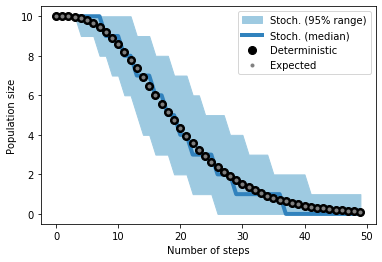

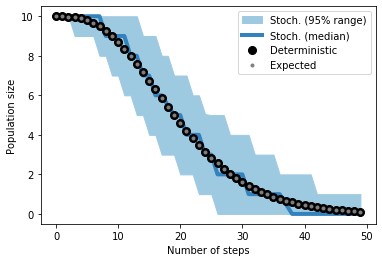

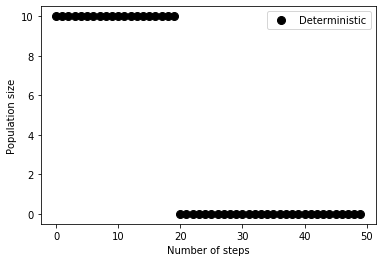

In [15]:
N = 10.0
mu = 20.0
sd = 10.0

def simDet(mode):
    a = spop(stochastic=False,gamma_fun=mode)
    a.add(0,0,0,0,N)
    retd = [[0]+a.read()]
    for n in numpy.arange(1,50):
        a.iterate(0,mu,sd,0,0,0)
        retd.append([n]+a.read())
    return numpy.array(retd)

def simStoch(mode):
    rets = []
    for r in range(1000):
        a = spop(stochastic=True,gamma_fun=mode)
        a.add(0,0,0,0,N)
        tmp = [[0]+a.read()]
        for n in numpy.arange(1,50):
            a.iterate(0,mu,sd,0,0,0)
            tmp.append([n]+a.read())
        rets.append(tmp)
    rets = numpy.array(rets)
    return numpy.percentile(rets,prange,axis=0)

modes = {
    'erlang':{'mode':'MODE_ACCP_ERLANG','figure':'1a'},
    'pascal':{'mode':'MODE_ACCP_PASCAL','figure':'1b'},
    'fixed':{'mode':'MODE_ACCP_FIXED','figure':'1c'}
}

for key in modes:
    if key=='pascal':
        theta = mu / (sd * sd)
        k = mu * theta / (1.0 - theta)
    elif key=='erlang':
        theta = sd * sd / mu
        k = mu / theta
    elif key=='fixed':
        theta = 1
        k = mu
    #
    retd = simDet(modes[key]['mode'])
    if not (key=='fixed'):
        retp = simStoch(modes[key]['mode'])
    #
    xr = numpy.arange(0,50,1)
    handles = []
    if not (key=='fixed'):
        handles.append(plt.fill_between(retp[1][:,0],retp[0][:,1],retp[2][:,1],color="#9ecae1",label="Stoch. (95% range)"))
        handles.append(plt.plot(retp[1][:,0],retp[1][:,1],c="#3182bd",label="Stoch. (median)",lw=4)[0])
    handles.append(plt.plot(retd[:,0],retd[:,1],'o',c="black",label="Deterministic",markersize=8)[0])
    if key=='pascal':
        handles.append(plt.plot(xr,N*(1.0-nbinom.cdf(xr-1,k,theta)),'.',c="gray",label="Expected",markersize=6)[0])
    elif key=='erlang':
        handles.append(plt.plot(xr,N*(1.0-erlang.cdf(xr,k,0,theta)),'.',c="gray",label="Expected",markersize=6)[0])
    plt.legend(handles,[handle.get_label() for handle in handles],loc="upper right")
    plt.ylabel("Population size")
    plt.xlabel("Number of steps")
    plt.savefig("figures/Figure%s.jpg" %(modes[key]['figure']),bbox_inches="tight",dpi=300)
    plt.show()

# Figure 2

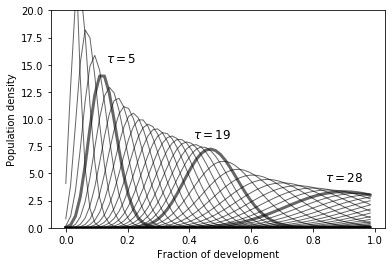

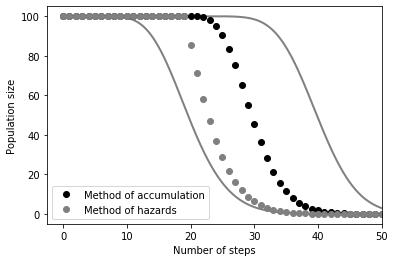

In [17]:
xr = numpy.arange(0,50,0.01)
xri = numpy.arange(0,200,1)
mu = numpy.array([40.0,20.0])
sd = numpy.array([5.0,5.0])
theta = sd * sd / mu
k = mu / theta

a = spop(stochastic=False,gamma_fun="MODE_GAMMA_HASH")
a.add(0,0,0,0,100)
retH = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retH.append([n]+a.read())
retH = numpy.array(retH)

a = spop(stochastic=False,gamma_fun="MODE_ACCP_ERLANG")
a.add(0,0,0,0,100)
retA = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retA.append([n]+a.read())
    retL.append(a.retrieve())
retA = numpy.array(retA)
retL = numpy.array(retL)

for i in range(len(retL)):
    r = retL[i]
    s = numpy.argsort(r[0])
    plt.plot(r[0][s],r[1][s],c="black",alpha=0.6,lw=3 if i in [5, 19, 28] else 1)
plt.text(0.13,15,r"$\tau=5$",horizontalalignment='left',verticalalignment='bottom',fontsize=12)
plt.text(0.475,8,r"$\tau=19$",horizontalalignment='center',verticalalignment='bottom',fontsize=12)
plt.text(0.9,4,r"$\tau=28$",horizontalalignment='center',verticalalignment='bottom',fontsize=12)
plt.ylim(0,20)
plt.ylabel("Population density")
plt.xlabel("Fraction of development")
plt.savefig("figures/Figure2a.jpg",bbox_inches="tight",dpi=300)
plt.show()

for i in numpy.arange(len(mu))[::-1]:
    plt.plot(xr,100*(1.0-erlang.cdf(xr,k[i],0,theta[i])),c="gray",lw=2)
plt.plot(xri,retA[:,1],'o',ms=6,c="black",label="Method of accumulation")
plt.plot(xri,retH[:,1],'o',ms=6,c="gray",label="Method of hazards")
plt.ylim(-5,105)
plt.xlim(-2.5,50)
plt.legend()
plt.ylabel("Population size")
plt.xlabel("Number of steps")
plt.savefig("figures/Figure2b.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Figure 1 (Life tables main manuscript)

[64. 16.] [0.625 1.25 ]


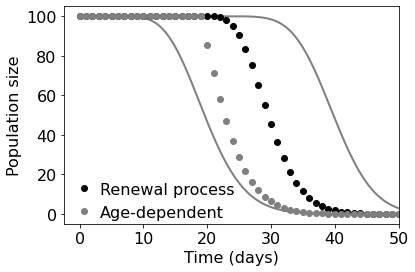

In [2]:
xr = numpy.arange(0,50,0.01)
xri = numpy.arange(0,200,1)
mu = numpy.array([40.0,20.0])
sd = numpy.array([5.0,5.0])
theta = sd * sd / mu
k = mu / theta
print(k,theta)

vecs = []
vec = numpy.repeat(0.0,xri.shape[0]); vec[0] = 100.0
vecs.append(vec)
for n in numpy.arange(1,20,1):
    vec = numpy.sum([(i <= xri) * vec[i] * poisson.pmf(xri-i,1.0/theta[0]) for i in xri],axis=0)
    vecs.append(vec)
#
tmp = numpy.sum(vec.reshape((50,4)),axis=1)
vec = numpy.repeat(0.0,xri.shape[0])
vec[:50] = tmp[:]
#
for n in numpy.arange(1,40,1):
    vec = numpy.sum([(i <= xri) * vec[i] * poisson.pmf(xri-i,1.0/theta[1]) for i in xri],axis=0)
    vecs.append(vec)
#
vecs = numpy.array(vecs)

a = spop(stochastic=False,gamma_fun="MODE_GAMMA_HASH")
a.add(0,0,0,0,100)
retH = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retH.append([n]+a.read())
retH = numpy.array(retH)

a = spop(stochastic=False,gamma_fun="MODE_ACCP_ERLANG")
a.add(0,0,0,0,100)
retA = [[0]+a.read()]
retL = [a.retrieve()]
for n in xri[1:]:
    i = 0 if n<20 else 1
    a.iterate(0,mu[i],sd[i],0,0,0)
    retA.append([n]+a.read())
    retL.append(a.retrieve())
retA = numpy.array(retA)
retL = numpy.array(retL)

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [6, 4]
for i in numpy.arange(len(mu))[::-1]:
    plt.plot(xr,100*(1.0-erlang.cdf(xr,k[i],0,theta[i])),c="gray",lw=2)
plt.plot(xri,retA[:,1],'o',ms=6,c="black",label="Renewal process")
plt.plot(xri,retH[:,1],'o',ms=6,c="gray",label="Age-dependent")
plt.ylim(-5,105)
plt.xlim(-2.5,50)
plt.legend(loc='lower left',borderpad=0,frameon=False,columnspacing=0,borderaxespad=0.25,handletextpad=0)
plt.ylabel("Population size")
plt.xlabel("Time (days)")
plt.savefig("figuresLT/figure_change_erlang_2.pdf",bbox_inches="tight",dpi=300)
plt.show()

# Figure 3a

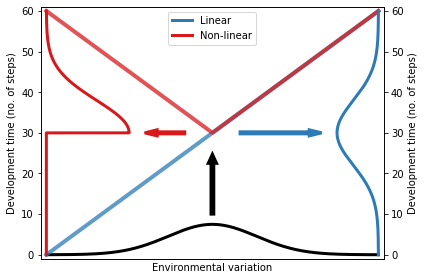

In [18]:
color = '#3182bd'

xr = numpy.arange(0,60,0.01)
yr = gaussian.pdf(xr,30,8)
zr = gaussian.pdf(xr,30,8)*2; zr[:int(zr.shape[0]/2)] = 0

fig, ax1 = plt.subplots()
ax1.set_xlim(-1,61)
ax1.set_ylim(-1,61)
ax1.set_xlabel("Environmental variation")
ax1.set_ylabel("Development time (no. of steps)", color="black")
plt.plot(xr,1.5e2*yr,color="black",lw=3)
plt.arrow(30,10,0,12.5,lw=3,width=0.5,linewidth=None,color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax1.xaxis.set_ticks([])
ax2 = ax1.twinx()
ax2.set_ylim(-1,61)
ax2.set_ylabel("Development time (no. of steps)", color="black")
plt.plot(xr,xr,lw=4,color="#2c7bb6",alpha=0.75)
plt.plot(xr,30+numpy.abs(xr-30),lw=4,color="#d7191c",alpha=0.75)
plt.plot(60-1.5e2*yr,xr,color="#2c7bb6",lw=3,label="Linear")
plt.arrow(25,30,-5,0,lw=3,width=0.5,linewidth=None,color="#d7191c")
plt.plot(1.5e2*zr,xr,color="#d7191c",lw=3,label="Non-linear")
plt.arrow(35,30,12.5,0,lw=3,width=0.5,linewidth=None,color="#2c7bb6")
ax2.tick_params(axis='y', labelcolor="black")
ax2.xaxis.set_ticks([])
plt.legend(loc="upper center")
fig.tight_layout()
plt.savefig("figures/Figure3a.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Figure 3b

Note: Due to the extended simulation time, the **figures_paper_sPop2_noise.py** was used to generate the data plotted in this section.

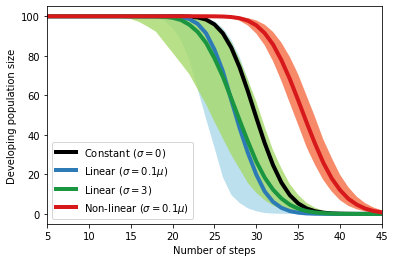

In [21]:
def sim(xr,mu,sd,mode):
    a = spop(stochastic=False,gamma_fun=mode)
    a.add(0,0,0,0,100)
    ret = []
    ret.append([0, 0, 0] + a.read())
    for i in numpy.arange(xr.shape[0]):
        a.iterate(0,mu[i],sd[i],0,0,0)
        ret.append([i+1,mu[i],sd[i]]+a.read())
    return numpy.array(ret)

cols = ["#abd9e9","#a6d96a","#f46d43","#fdae61"]
colss = ["#2c7bb6","#1a9641","#d7191c","#d7191c"]
xr = numpy.arange(0,50,1)

detA = sim(xr,numpy.repeat(30,xr.shape[0]),numpy.repeat(0.1*30,xr.shape[0]),"MODE_ACCP_ERLANG")
retAs = [
    numpy.percentile(numpy.load("mat/figures_paper_noise3_retAs_rs0.npy"),prange,axis=0),
    numpy.percentile(numpy.load("mat/figures_paper_noise3_retAs_approx_sd2_rs0.npy"),prange,axis=0),
    numpy.percentile(numpy.load("mat/figures_paper_noise3opt_retAs_rs0.npy"),prange,axis=0)
]

labels = [r"Linear ($\sigma=0.1\mu$)",r"Linear ($\sigma=3$)",r"Non-linear ($\sigma=0.1\mu$)",r"Non-linear ($\sigma=3$)"]
plt.plot(detA[:,0],detA[:,3],c="black",lw=4,label=r"Constant ($\sigma=0$)")
for i in range(len(retAs)):
    ret = retAs[i]
    plt.fill_between(ret[1][:,0],ret[0][:,3],ret[2][:,3],facecolor=cols[i],edgecolor='none',alpha=0.8,lw=2)
    plt.plot(ret[1][:,0],ret[1][:,3],c=colss[i],lw=4,label=labels[i])
plt.legend(loc="lower left")
plt.ylabel("Developing population size")
plt.xlabel("Number of steps")
plt.xlim(5,45)
plt.savefig("figures/Figure3b.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Figure S1

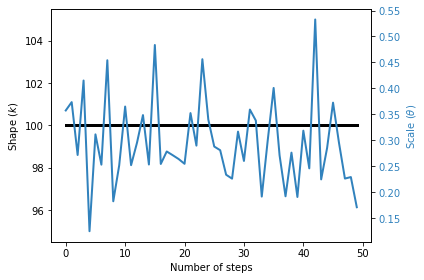

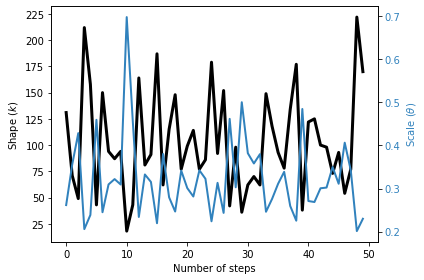

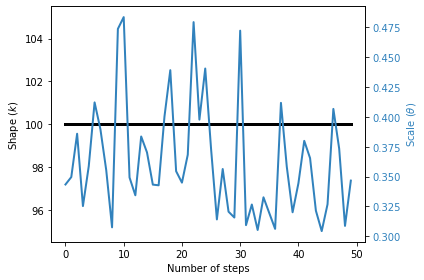

In [24]:
def getDev(xr,r):
    dev = normal(30.0, r, xr.shape[0])
    dev[dev < 3.0] = 3.0
    return dev

def getDevOpt(n,r):
    dev = normal(30.0, r, xr.shape[0])
    dev = 30.0 + numpy.abs(dev - 30.0)
    return dev

cols = ["gray","lightgray"]
colss = ["black","gray"]
xr = numpy.arange(0,50,1)

yr0 = getDev(xr,8); yr0s = 0.1*yr0
k0 = numpy.round((yr0/yr0s)**2); theta0 = yr0/k0
yr1 = getDev(xr,8); yr1s = numpy.repeat(3.0,yr1.shape[0])
k1 = numpy.round((yr1/yr1s)**2); theta1 = yr1/k1
yr2 = getDevOpt(xr,8); yr2s = 0.1*yr2
k2 = numpy.round((yr2/yr2s)**2); theta2 = yr2/k2

kk = [k0,k1,k2]
tt = [theta0,theta1,theta2]

for i in range(len(kk)):
    fig, ax1 = plt.subplots()
    color = 'black'
    ax1.set_xlabel("Number of steps")
    ax1.set_ylabel(r"Shape ($k$)", color=color)
    ax1.plot(xr, kk[i], color=color, lw=3)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = '#3182bd'
    ax2.set_ylabel(r"Scale ($\theta$)", color=color)
    ax2.plot(xr, tt[i], color=color, lw=2)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.savefig("figures/FigureS1%s.jpg" %(['a','b','c'][i]),bbox_inches="tight",dpi=300)
    plt.show()

# Figure S2

Note: Due to the extended simulation time, the **figures_paper_noise.py** was used to generate the data plotted in this section.

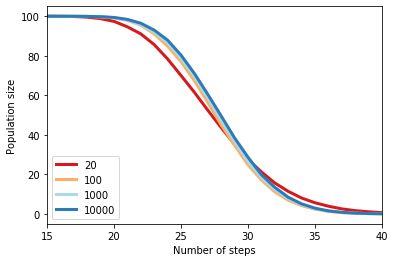

In [25]:
retAs = [
    numpy.percentile(numpy.load("mat/figures_paper_noise3_retAs_approx_sd2_rs0_0.05.npy"),prange,axis=0),
    numpy.percentile(numpy.load("mat/figures_paper_noise3_retAs_approx_sd2_rs0_0.01.npy"),prange,axis=0),
    numpy.percentile(numpy.load("mat/figures_paper_noise3_retAs_approx_sd2_rs0.npy"),prange,axis=0)
]
r = numpy.vstack([numpy.load("mat/figures_paper_noise3_retAs_approx_sd2_rs0_0.0001_%d.npy" %(j)).tolist() for j in range(10)])
retAs.append(numpy.percentile(r,prange,axis=0))

cols = ["#d7191c","#fdae61","#abd9e9","#2c7bb6"]
labels = ["20","100","1000","10000"]
for i in range(len(retAs)):
    ret = retAs[i]
    plt.plot(ret[1][:,0],ret[1][:,3],c=cols[i],lw=3,label=labels[i])
plt.legend(loc="lower left")
plt.ylabel("Population size")
plt.xlabel("Number of steps")
plt.xlim(15,40)
plt.savefig("figures/FigureS2.jpg",bbox_inches="tight",dpi=300)
plt.show()